# Crochet and Knitting Patterns
Predicting pattern difficulty from pattern attributes 

Ravelry.com hosts tens of thousands of crochet and knitting patterns created by users, some for sale, others offered up for free. Ravelry's free API provides rich detail for each, including features like yarn weight, gauge, yardage, tags, author information, and community ratings for the quality of the pattern as well as its difficulty.

Is it possible to infer how challenging a pattern is to complete from these features? I built a dataset from the API, explored and prepared the data, and fit a simple linear regression model to find out.

In [131]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

# refer to pattern_details_ravelry.py for creating this dataset via the Ravelry API
pattern_details = pd.read_csv('~/kp_git/crochet_patterns/pattern_details.csv')

### The Model 
For this analysis, we will use [**linear regression**](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f) to understand the relationship between pattern difficulty and pattern attributes. Assumptions of linear regression include: 

- Linear relationship
- Multivariate normality 
- No multicollinearity 
- Homoskedacity of the residuals 

### Data Exploration 
First, let's inspect the data.  

In [132]:
pattern_details.shape

(7056, 54)

In [133]:
pattern_details.columns

Index(['sub_category_permalink', 'category_permalink', 'id', 'comments_count',
       'created_at', 'currency', 'currency_symbol', 'difficulty_average',
       'difficulty_count', 'download_location', 'downloadable',
       'favorites_count', 'free', 'gauge', 'gauge_description',
       'gauge_divisor', 'gauge_pattern', 'generally_available', 'name',
       'notes', 'notes_html', 'packs', 'pattern_attributes',
       'pattern_categories', 'pattern_needle_sizes', 'pattern_type',
       'pdf_in_library', 'pdf_url', 'permalink', 'personal_attributes',
       'photos', 'price', 'printings', 'product_id', 'projects_count',
       'published', 'queued_projects_count', 'rating_average', 'rating_count',
       'ravelry_download', 'row_gauge', 'sizes_available', 'updated_at', 'url',
       'volumes_in_library', 'yardage', 'yardage_description', 'yardage_max',
       'yarn_weight', 'yarn_weight_description', 'craft_permalink',
       'author_permalink', 'author_id', 'author_patterns_count'],
   

In [134]:
pattern_details.groupby('category_permalink').count()['id'].sort_values(ascending = False)

category_permalink
clothing             1845
home                 1550
toysandhobbies       1229
pattern-component    1010
accessories           910
pet                   512
Name: id, dtype: int64

In [135]:
pattern_details.groupby('craft_permalink').count()['id'].sort_values(ascending = False)

craft_permalink
knitting            3935
crochet             3110
loom-knitting          6
machine-knitting       5
Name: id, dtype: int64

We have about 7000 pattern observations, primarily from the clothing and home categories, and pretty evenly split between knitting and crochet.  

#### The dependent variable  

Next, let's understand the dependent variable, `difficulty_average`, or the average difficulty rating given to a pattern by Ravelry users.  

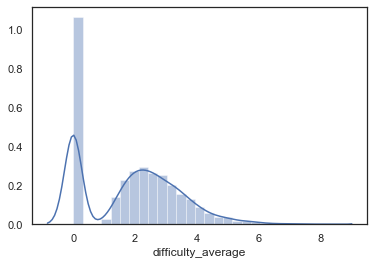

In [136]:
sns.distplot(pattern_details['difficulty_average']);

There are a large number of patterns with a difficulty score of 0, which likely means they have no difficulty ratings.  

In [137]:
pattern_details[pd.isna(pattern_details['difficulty_count'])].shape

(2272, 54)

More than 2200 patterns have `NaN` values for `difficulty_count`. Excluding them refocuses the `difficulty_average` histogram. 

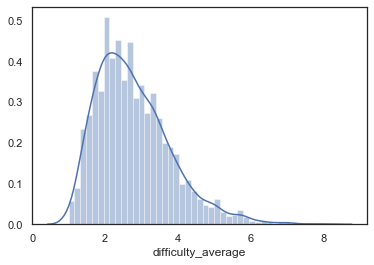

In [138]:
pattern_details = pattern_details[pd.isna(pattern_details['difficulty_count']) == False]

sns.distplot(pattern_details['difficulty_average']);

Is just removing missing values enough? What's the minimum `difficulty_count` that will provide a reliable `difficulty_average` value? 

In [139]:
pattern_details['difficulty_count'].count()

4784

In [140]:
pattern_details.loc[(pattern_details['difficulty_count'] >= 5), 'difficulty_count'].count()

3983

In [141]:
pattern_details.loc[(pattern_details['difficulty_count'] >= 30), 'difficulty_count'].count()

1797

We lose about 800 patterns if we restrict the dataset to observations with at least 5 difficulty ratings. We would lose 3000 if we required 30 ratings. 

In [142]:
pattern_details = pattern_details[pattern_details['difficulty_count'] >= 5]

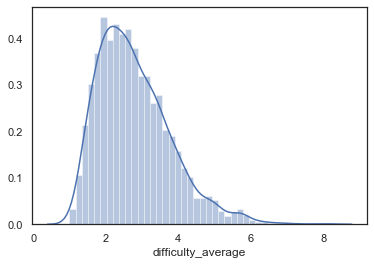

In [143]:
sns.distplot(pattern_details['difficulty_average']);

In [144]:
pattern_details.groupby('category_permalink').count()['id'].sort_values(ascending = False)

category_permalink
clothing             1153
home                  893
accessories           641
toysandhobbies        629
pattern-component     425
pet                   242
Name: id, dtype: int64

In [145]:
pattern_details.groupby('craft_permalink').count()['id'].sort_values(ascending = False)

craft_permalink
knitting            2546
crochet             1434
loom-knitting          2
machine-knitting       1
Name: id, dtype: int64

After removing the patterns missing difficulty ratings, the dataset has a similar category distribution, though it leans slightly more toward knitting than it did before.

One of the central assumptions of linear regression is the normality of the dependent variable. Is `difficulty_average` normally distributed, or do we need to transform it?  

We'll use a [Quantile-Quantile plot, or qqplot,](http://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html) to assess normality. Points along the diagonal indicate a normal distribution.  

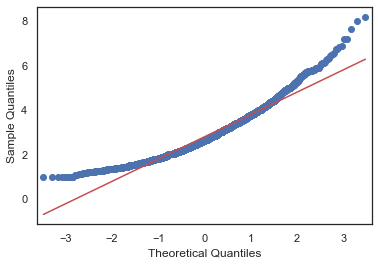

In [146]:
qqplot(pattern_details['difficulty_average'], line = 's');

The data is not normal! Let's try a square root transformation.

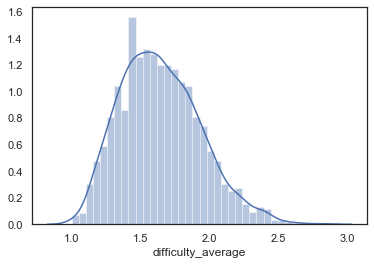

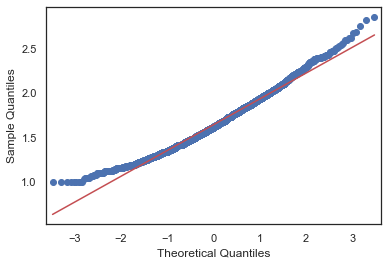

In [147]:
sns.distplot(pattern_details['difficulty_average'].apply(math.sqrt));
qqplot(pattern_details['difficulty_average'].apply(math.sqrt), line = 's');

Close! Let's go one degree further with a cube root.

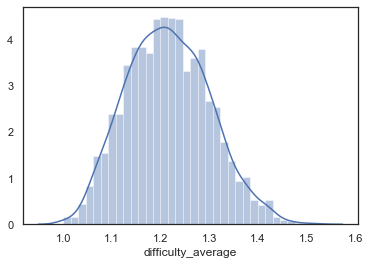

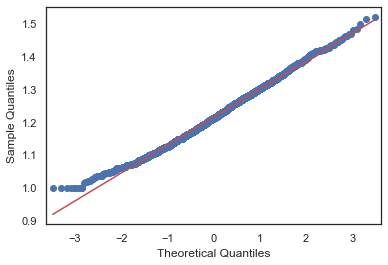

In [151]:
sns.distplot(pattern_details['difficulty_average'].apply(lambda x: x ** (1./5)));
qqplot(pattern_details['difficulty_average'].apply(lambda x: x ** (1./5)), line = 's');

In [152]:
pattern_details['difficulty_average_transformed'] = pattern_details['difficulty_average'].apply(lambda x: x ** (1./5))

### Preparing the data for modeling  
Let's create a few binary variables from categorical variables, and use one-hot encoding to prepare the other categorical variables for modeling. 
Next, we'll check the correlation between all variables to see if any are collinear and can be removed. 


In [153]:
# create binary vars
pattern_details['is_usd'] = pattern_details['currency'].apply(lambda x: 1 if x in ['USD'] else 0)
pattern_details['is_crochet'] = pattern_details['craft_permalink'].apply(lambda x: 1 if x in ['crochet'] else 0)
pattern_details['free'] *= 1
yarn_weight_major_groups = ['Worsted (9 wpi)', 'DK (11 wpi)', 'Fingering (14 wpi)', 'Aran (8 wpi)','Sport (12 wpi)']
pattern_details['yarn_weight_grouped'] = pattern_details['yarn_weight_description'].apply(lambda x: x if x in yarn_weight_major_groups else 'Other')

In [154]:
# one hot encoding for categorical vars
encoded_vars = pd.get_dummies(pattern_details[['category_permalink', 'yarn_weight_grouped']])

In [155]:
# remove excess variables from the dataset
vars_of_interest = ['author_patterns_count','price', 'comments_count', 'free', 'is_usd', 'is_crochet',
              'difficulty_average_transformed', 'difficulty_count', 'favorites_count', 
              'projects_count', 'queued_projects_count', 'rating_average', 'rating_count', 
              'gauge', 'gauge_divisor', 'yardage', 'yardage_max']

pattern_details_clean = pattern_details[vars_of_interest].join(encoded_vars)

In [156]:
pattern_corr = pattern_details_clean.corr()

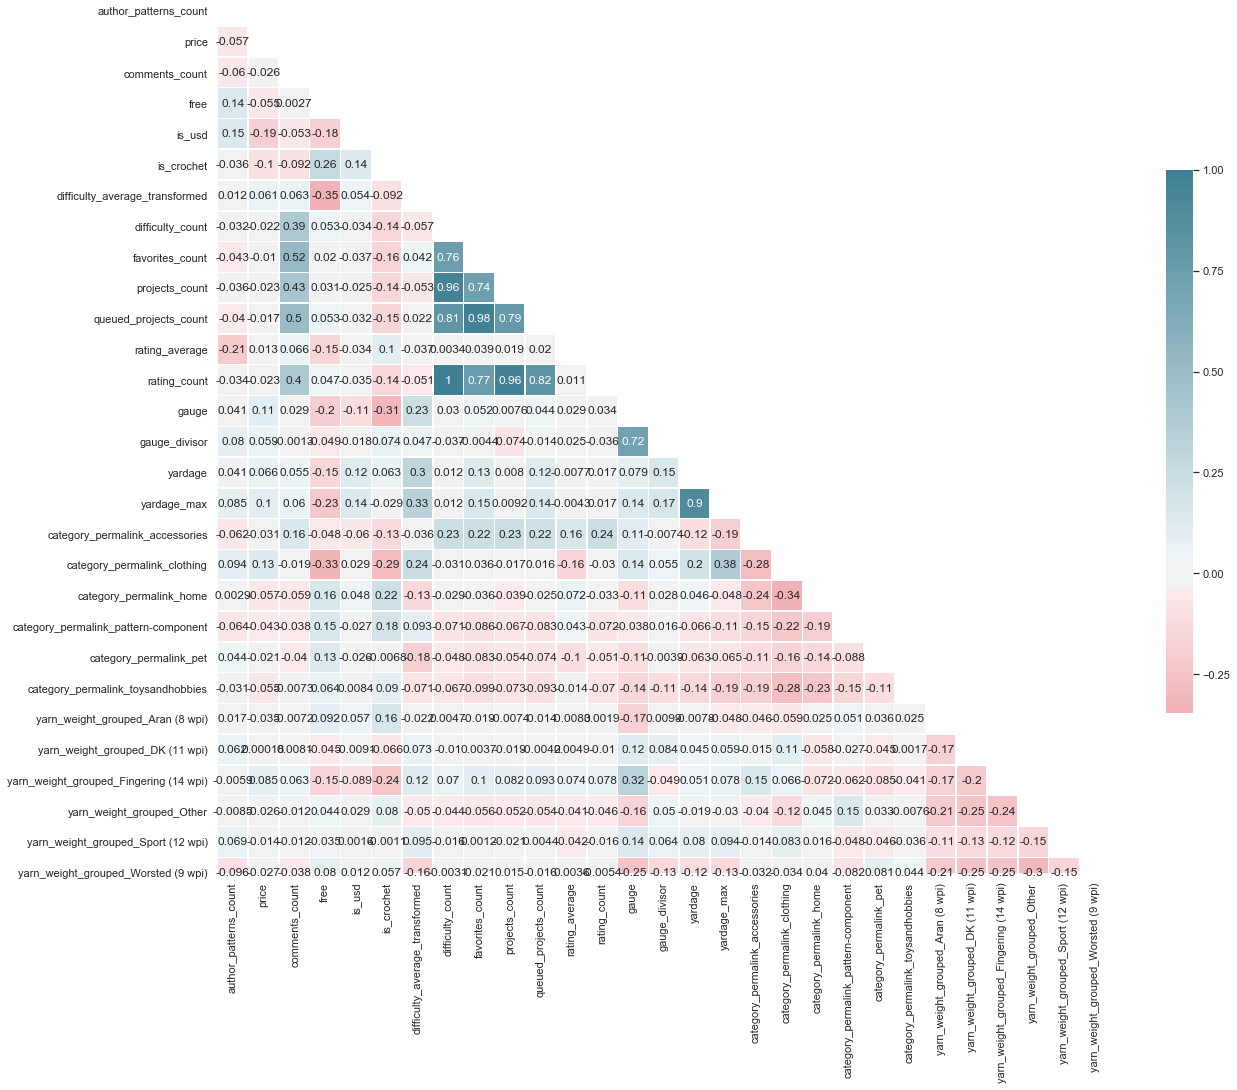

In [157]:
#https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")
plt.figure(figsize=(20,20))
mask = np.zeros_like(pattern_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(pattern_corr, mask = mask, cmap = cmap, center = 0, annot = True, 
            square = True, linewidths=.5, cbar_kws={"shrink": .5});

Several of the count variables are highly correlated (> 0.80) - `projects_count`, `queued_projects_count`, `rating_count` and `difficulty_count`. As would be expected, the encoded `category_permalink` and `yarn_weight_grouped` variables are negatively correlated with each other.  

`is_crochet` is negatively associated with `gauge`, the clothing category, and fingering weight yarn, as well as `price`, `rating_average` and `diffciulty_average`. Crochet patterns are more likely than knit patterns to be `free`, use aran weight yarn, and be in the home or pattern-component categories.   

More difficult patterns are associated with the clothing category, longer `yardage`, higher `gauge`, knitting, fingering weight yarn, and have more comments. 

In [158]:
# remove collinear variables
pattern_details_clean = pattern_details_clean.drop('projects_count', axis = 1)
pattern_details_clean = pattern_details_clean.drop('queued_projects_count', axis = 1)
pattern_details_clean = pattern_details_clean.drop('rating_count', axis = 1)
adjusted_pattern_corr = pattern_details_clean.corr()

### Modelling 
Separate the dataset into the independent variables (X) and the response variable (Y), and then split into 80% training and 20% testing.  


In [159]:
X = np.array(pattern_details_clean.drop('difficulty_average_transformed', axis = 1))
X = np.nan_to_num(X)

Y = np.array(pattern_details_clean['difficulty_average_transformed']).reshape(-1,1)

In [160]:
train_data, test_data, train_response, test_response = train_test_split(X, Y, test_size=0.2, random_state=0)

Fit a linear regression model. 

In [161]:
lm = LinearRegression()
lm.fit(train_data, train_response)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Predict the response variable in the training set, adjusting any outlier predictions back inside the 0,10 `difficulty_average` range. 

In [162]:
train_pred = lm.predict(train_data)
train_pred[train_pred < 0] = 0
train_pred[train_pred > 10] = 10
train_rmse = mean_squared_error(train_response, train_pred)
train_r2 = r2_score(train_response, train_pred)
print('RMSE is {} and r2 is {} for the train set'.format(round(train_rmse,3), round(train_r2,3)))

RMSE is 0.005 and r2 is 0.254 for the train set


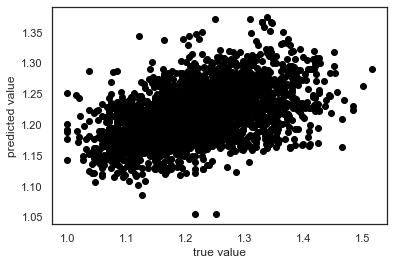

In [163]:
plt.plot(train_response, train_pred, 'o', color = 'black')
plt.xlabel('true value'),
plt.ylabel('predicted value');

Check the residuals for heteroskedacity. Looks good!

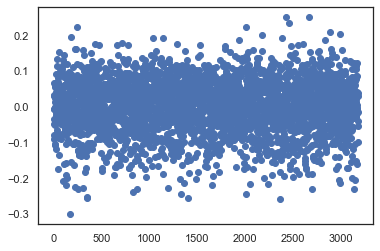

In [164]:
train_residuals = pd.DataFrame(train_pred - train_response)
train_residuals.columns = ['y']
train_residuals['x'] = train_residuals.index
plt.plot(train_residuals['x'], train_residuals['y'], 'o');

Predict the response variable in the test set, adjusting any outlier predictions back inside the 0,10 `difficulty_average` range. 

In [165]:
test_pred = lm.predict(test_data)
test_pred[test_pred < 0] = 0
test_pred[test_pred > 10] = 10
test_rmse = mean_squared_error(test_response, test_pred)
test_r2 = r2_score(test_response, test_pred)

print('RMSE is {} and r2 is {} for the test set'.format(round(test_rmse,3), round(test_r2,3)))

RMSE is 0.006 and r2 is 0.246 for the test set


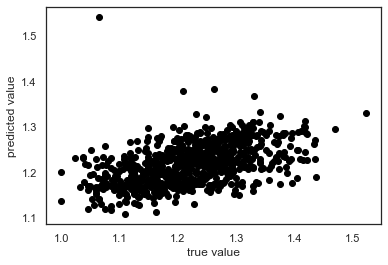

In [166]:
plt.plot(test_response, test_pred, 'o', color = 'black')
plt.xlabel('true value'),
plt.ylabel('predicted value');

Check the residuals.

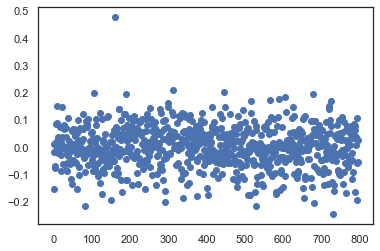

In [167]:
test_residuals = pd.DataFrame(test_pred - test_response)
test_residuals.columns = ['y']
test_residuals['x'] = test_residuals.index
plt.plot(test_residuals['x'], test_residuals['y'], 'o');